# Low-rank approximation of images

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import ipython_blocking

from PIL import Image
from numpy import linalg as LA

from ipywidgets import FileUpload

In [2]:
CHANNELS = 'RGBA'
DPI = 150

## Read image from file chooser

In [3]:
upload = FileUpload(accept='.png', multiple=False)
upload

FileUpload(value={}, accept='.png', description='Upload')

In [15]:
%block upload

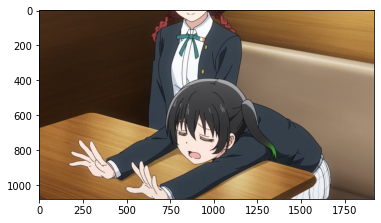

In [5]:
with open('input.png', 'w+b') as i:
    i.write(upload.data[0])

img = Image.open('input.png').convert(CHANNELS)
img = np.array(img)
plt.imshow(img)
plt.show()

In [6]:
img.shape

(1080, 1920, 4)

In [7]:
npimg = np.transpose(img, (2, 0, 1))
npimg.shape

(4, 1080, 1920)

## Singular Value Decomposition

Recall that any matrix $A\in\mathbb{R}^{m,n}$ can be decomposed as a sum of dyads (rank-one matrices, outer product of 2 vectors):

$$A = \sum_{i=1}^r \sigma_i p_i q_i^T=U_rSV_r^T$$

where:
- $r=\text{rank}(A)$,
- $U_r = \begin{bmatrix}u_1 & \dots & u_r\end{bmatrix}$ such that $U_r^TU_r=I_r$, and
- $V_r = \begin{bmatrix}v_1 & \dots & v_r\end{bmatrix}$ such that $V_r^TV_r=I_r$, and
- $\sigma_1 \ge \dots \ge \sigma_r \gt 0$.

$\sigma_i$ are called singular values of $A$.

Consider `npimg` as a stacking array of matrices of 4 color channels (R,G,B,A), we will decompose each of them independently.

In [8]:
U, S, VT = LA.svd(npimg, full_matrices=False)

In [9]:
for i, ch in enumerate(CHANNELS):
    print(f'Rank of channel {ch}: {sum(S[i] > 0)}')

Rank of channel R: 1080
Rank of channel G: 1080
Rank of channel B: 1080
Rank of channel A: 1080


## Input your rank approximation here

In [10]:
lowrank = []

while (len(lowrank) != len(CHANNELS)):
    print(f'Type rank approx. of channels {CHANNELS.replace("", " ").strip()} (separated by space):')
    lowrank = list(map(int, input().split()))
    
    invalid = len(lowrank) != len(CHANNELS)
    for i in range(len(CHANNELS)):
        if (lowrank[i] < 1) or (lowrank[i] > sum(S[i] > 0)):
            invalid = True
            break
            
    if invalid:
        print('Invalid rank(s)')
        lowrank = []

print(f'Low rank approx. of {CHANNELS}: {lowrank}')

Type rank approx. of channels R G B A (separated by space):
123 456 233 45
Low rank approx. of RGBA: [123, 456, 233, 45]


## Low-rank approximation

Choose a value $1 \le k \le \text{rank}(A)$, then sum up as below:

$$A_k = \sum_{i=1}^k \sigma_i p_i q_i^T$$

In [11]:
npout = np.zeros(npimg.shape)

for ch in range(npimg.shape[0]):
    for i, sig in enumerate(S[ch,:lowrank[ch]]):
        du = U[ch,:,i, np.newaxis]
        dv = VT[ch, i, np.newaxis]

        npout[ch] += sig * (du @ dv)

In [12]:
output = np.transpose(np.rint(npout).astype(int), (1, 2, 0))
output.shape

(1080, 1920, 4)

## Image output

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


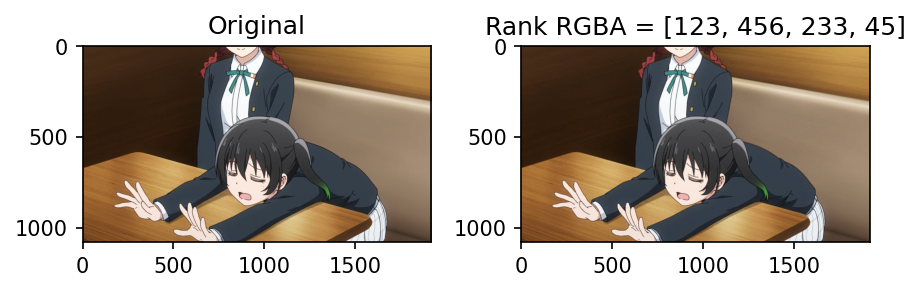

In [13]:
pimg, iaxs = plt.subplots(1,2)
iaxs = iaxs.flatten()

iaxs[0].set_title('Original')
iaxs[0].imshow(img)

iaxs[1].set_title(f'Rank RGBA = {lowrank}')
iaxs[1].imshow(output)

pimg.set_dpi(DPI)

plt.tight_layout()
plt.show()

## Norm approximation error

The below ratio indicates what fraction of the total Frobenius norm in $A$ is "explained" by the rank $k$ approximation of $A$.

$$\eta_k = \frac{\|A_k\|_F^2}{\|A\|_F^2}=\frac{\sigma_1^2 +\dots + \sigma_k^2}{\sigma_1^2 +\dots + \sigma_r^2}$$

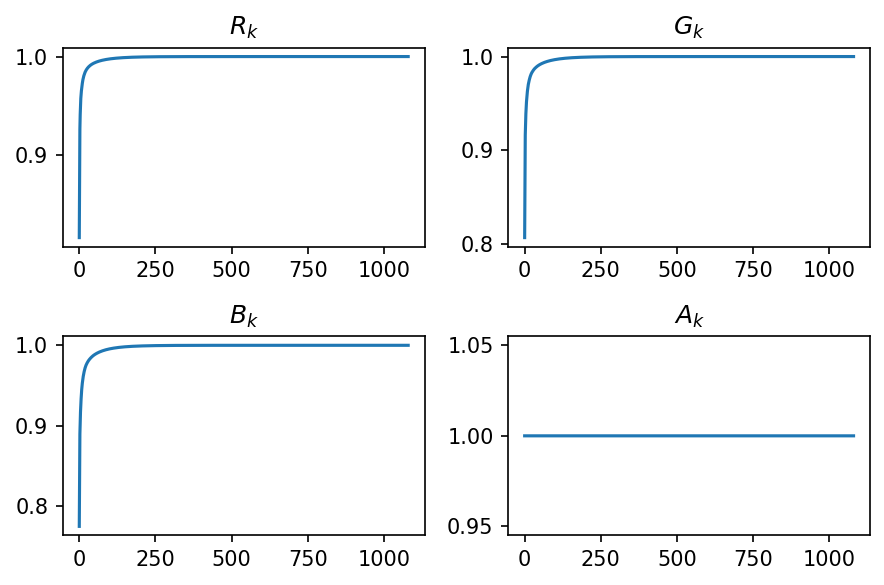

In [14]:
perr, eaxs = plt.subplots(2, 2)
eaxs = eaxs.flatten()

for i, ch in enumerate(CHANNELS):
    eaxs[i].set_title(f'${ch}_k$')

    err = np.zeros(len(S[i]))
    
    for k in range(len(S[i])):
        pre = 0
        if (k > 0):
            pre = err[k - 1]
        err[k] = pre + S[i, k] ** 2

    err /= sum(S[i] ** 2)

    eaxs[i].plot(err)

perr.set_dpi(DPI)

plt.tight_layout()
plt.show()